In [4]:
%reload_ext zipline
%matplotlib inline

In [5]:
from zipline.utils import factory
from zipline.api import symbol, order, record
import numpy as np
from datetime import datetime, date
import pytz
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import os
import collections
from StringIO import StringIO
from zipline.protocol import BarData
from zipline.utils.factory import load_bars_from_yahoo
import scipy.stats as stats

In [6]:
parse = lambda x: datetime.strptime(x, '%d-%m-%y').date()

dict={}
array = np.array(['BTCUSD','LTCUSD','DOGEBTC','SPY','XRPUSD','DASHBTC','MAIDBTC','XMRBTC','BTSBTC','BTCETH','FCTBTC'])


for x in array:
    dict["{0}".format(x)] = pd.read_csv('/Users/JH/Desktop/Business/GGSB Thesis 2016/Code/excelled data/'+x+'.csv', index_col=['Timestamp'], 
                                  usecols=['Timestamp','Open','High','Low','Close','Volume','VWAP'], sep=';',
                                  parse_dates=True, date_parser=parse).tz_localize('UTC')
# 
# start = datetime(2014, 04, 01, 0, 0, 0, 0, pytz.utc)
# end = datetime(2016, 06, 11, 0, 0, 0, 0, pytz.utc)
# data = load_bars_from_yahoo(stocks=['SPY'],start=start,end=end)
# print data
# dict['SPY'] = data

dictData = collections.OrderedDict()
dictData = dict
# print dictData

In [7]:
panel = pd.Panel(dictData)
panel.minor_axis = ['open', 'high', 'low', 'close', 'volume','vwap']
# panel.drop('vwap','minor_axis') doesn't work? 
print(panel)
df = panel.to_frame()
# print df

# COVARIANCES
# print df.cov()

# CORRELATIONS
# print df.corr()


# Rolling standard deviations (volatilities)
for x in array:
    df_std = panel[x]['vwap']
    std_plot = pd.rolling_std(df_std, 2)
    print x, std_plot.dropna().count(), sum(std_plot.dropna()) / std_plot.count()
    
# Having a look at the lognormal distributions
# for x in array:
#     st = stats.normaltest(panel[x]['vwap'].dropna())
#     print x, st

# ax1 = plt.subplot(621)
# std_plot.plot(ax=ax1)
# plt.gcf().set_size_inches(50,40)
# plt.ylabel('Moving standard deviation')
# # plt.savefig('btceth.png',bbox_inches='tight')
# plt.show()

<class 'pandas.core.panel.Panel'>
Dimensions: 11 (items) x 803 (major_axis) x 6 (minor_axis)
Items axis: BTCETH to XRPUSD
Major_axis axis: 2014-04-01 00:00:00+00:00 to 2016-06-11 00:00:00+00:00
Minor_axis axis: open to vwap
BTCUSD 802 4.63653824709
LTCUSD 802 0.0794507553079
DOGEBTC 802 4.81984084348e-06
SPY 435 0.707106781187
XRPUSD 772 0.000196344883217
DASHBTC 772 0.117937216276
MAIDBTC 711 0.000934094263781
XMRBTC 711 0.0242994692127
BTSBTC 619 0.000189437802118
BTCETH 222 0.134841392113
FCTBTC 130 0.0453565907413


In [43]:
# Simulation parameters

sim_params = factory.create_simulation_parameters(
    start=pd.to_datetime("01-04-14", dayfirst=True).tz_localize("Europe/London").tz_convert("UTC"),
    end=pd.to_datetime("11-06-16", dayfirst=True).tz_localize("Europe/London").tz_convert("UTC"),
    data_frequency="daily",
    emission_rate="daily")

# data = data.dropna()

In [44]:
# Analysis imports

from zipline.algorithm import TradingAlgorithm, log
from zipline.api import order, order_target_percent, symbol, get_datetime, set_commission, commission, set_slippage, slippage, history, symbols, sid

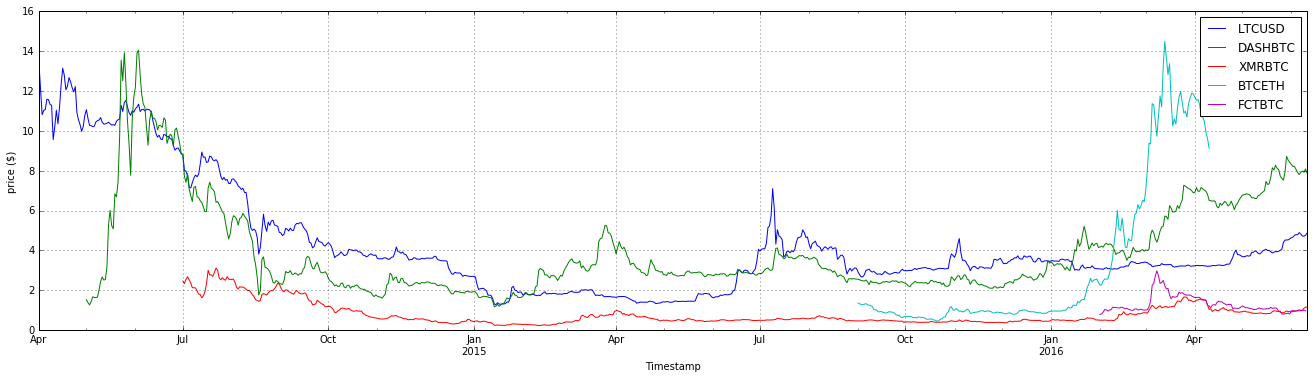

In [140]:
# Initial visuals

ax1 = plt.subplot(621)
# del dictData['BTCUSD']['Volume']
# dictData['BTCUSD']['Volume']
# SEE https://stats.stackexchange.com/questions/19426/scaling-data-that-are-on-different-scales-for-a-graph
# ax2 = ax1.twinx()
leaveOut = ['BTCUSD','MAIDBTC','XRPUSD']
for x in array:
    if x == 'MAIDBTC' or x == 'XRPUSD' or x == 'BTSBTC' or x == 'DOGEBTC' or x == 'BTCUSD': 
        # dictData[x]['VWAP'].plot(ax=ax1,label=str(x))
        pass
    else:
        # pass
        dictData[x]['VWAP'].plot(ax=ax1,label=str(x))
plt.ylabel('price ($)')
# ax1.lines.pop(4)
plt.gcf().set_size_inches(50,40)
plt.legend()
plt.setp(ax1.get_xticklabels(), visible=True)
ax1.get_xaxis().set_visible(True)
# ax1.get_xaxis().set_ticks([])
plt.grid(True)
plt.savefig('0_16_crypts.png',bbox_inches='tight')

In [239]:
# ACTUAL ETF BACKTESTING

#      order(symbol('BTCUSD'), 1000)
#      order(symbol('LTCUSD'), 10)
#      order(symbol('DOGEBTC'), 100)
# if event_day == algo.days[1]: 
#     # 20%
#     order(symbol('XRPUSD'), 1000)
#     order(symbol('DASHBTC'), 10000)
# if event_day == algo.days[2]:
#     # 14%
#     order(symbol('MAIDBTC'), 10000)
#     order(symbol('XMRBTC'), 10000)
# if event_day == algo.days[3]:
#     # 12.5%
#     order(symbol('BTSBTC'), 10000)
# if event_day == algo.days[4]:
#     # 11.1%
#     order(symbol('BTCETH'), 10000)
# if event_day == algo.days[5]:
#     # 10%
#     order(symbol('FCTBTC'), 10000)

# This is only used if wanting to leave out elements in symbol array
edit = False
if edit:
    a = np.ma.array(array, mask=False)
    a.mask[4] = True
else:
    a = array

def initialize(algo):
    algo.assets = symbols('BTCUSD','LTCUSD','DOGEBTC','XRPUSD','DASHBTC','MAIDBTC','XMRBTC','BTSBTC','BTCETH','FCTBTC')
    algo.days = [   
                    # Days on which new asset becomes available
                    date(2014,4,1),date(2014,5,1),date(2014,7,1),date(2014,10,1),date(2015,9,1),date(2016,2,1), 
                    # Rebalancing dates, every third Friday quarterly
                    date(2014,6,20), date(2014,9,19), date(2014,12,14), date(2015,3,20), date(2015,6,19), date(2015,9,18), date(2015,12,15), date(2016,3,18), date(2016,6,17)
                ]
    
    # Slippage 
    # set_slippage(slippage.FixedSlippage(spread=0.0))
    # Commission model 
    # set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))

    #set_commission(commission.PerTrade(cost=0.00))
    
    # Slippage = default (max 2.5% of volume)
    
    # Commission model 
    set_commission(commission.PerTrade(cost=0.002))
    
# ETF trading 'strategy'
def handle_data(algo, data):
    
    # # Getting the daily returns
    # hist = data.history(algo.assets, 'close', 555, '1d').dropna()
    # # print hist
    # simple_returns = hist.pct_change().dropna()
    # # print simple_returns
    # log_returns = np.log(hist/hist.shift(1))
    # 
    # # Getting the average return
    # avg_simple_return = simple_returns.mean()
    # avg_log_return = log_returns.mean()
    # 
    # # Standard deviation of returns
    # stdev = simple_returns.std()
    # 
    # record(
    #     apple=avg_simple_return[symbol('BTCUSD')]*100,
    #     apple_dev=stdev[symbol('BTCUSD')]*100,
    # )
    
    # # Standard deviation of returns
    # stdev = simple_returns.std()
    # 
    # log.info(avg_simple_return)
    # 
    
    event_day = get_datetime(None).date()
    
    # Buy-and-hold Symbol x
    # if event_day == algo.days[5]: 
    #     order_target_percent(symbol('FCTBTC'), 1)
        
    # WEIGHTING: equal weighting (needs consistent rebalancing - right now only rebalances when new symbol data becomes available)    
    # if event_day == algo.days[0]: 
    #     # 33% each
    #     for s in a[:3]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.33)
    # if event_day == algo.days[1]: 
    #     # 20%
    #     for s in a[:5]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.2)
    # if event_day == algo.days[2]:
    #     # 14%
    #     for s in a[:7]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.14)
    # if event_day == algo.days[3]:
    #     # 12.5%
    #     for s in a[:8]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.125)
    # if event_day == algo.days[4]:
    #     # 11.1%
    #     for s in a[:9]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.111)
    # if event_day == algo.days[5]:
    #     # 10%
    #     for s in a:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.1)

    # WEIGHTING: market cap weightings (no quarterly adjustments)
    # if event_day == algo.days[0]: 
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9449)
    #     order_target_percent(symbol('LTCUSD'), 0.0493)
    #     order_target_percent(symbol('DOGEBTC'), 0.0058)  
    # if event_day == algo.days[1]: 
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9344)
    #     order_target_percent(symbol('LTCUSD'), 0.0516)
    #     order_target_percent(symbol('DOGEBTC'), 0.0058) 
    #     order_target_percent(symbol('XRPUSD'), 0.0069)
    #     order_target_percent(symbol('DASHBTC'), 0.0011) 
    # if event_day == algo.days[2]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9597)
    #     order_target_percent(symbol('LTCUSD'), 0.0286)
    #     order_target_percent(symbol('DOGEBTC'), 0.0025) 
    #     order_target_percent(symbol('XRPUSD'), 0.0034)
    #     order_target_percent(symbol('DASHBTC'), 0.0045)
    #     order_target_percent(symbol('MAIDBTC'), 0.0009)
    #     order_target_percent(symbol('XMRBTC'), 0.0005) 
    # if event_day == algo.days[3]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9267)
    #     order_target_percent(symbol('LTCUSD'), 0.026)
    #     order_target_percent(symbol('DOGEBTC'), 0.0064) 
    #     order_target_percent(symbol('XRPUSD'), 0.0245)
    #     order_target_percent(symbol('DASHBTC'), 0.0023)
    #     order_target_percent(symbol('MAIDBTC'), 0.0015)
    #     order_target_percent(symbol('XMRBTC'), 0.0008) 
    #     order_target_percent(symbol('BTSBTC'), 0.0118)
    # if event_day == algo.days[4]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8672)
    #     order_target_percent(symbol('LTCUSD'), 0.0303)
    #     order_target_percent(symbol('DOGEBTC'), 0.0033) 
    #     order_target_percent(symbol('XRPUSD'), 0.0647)
    #     order_target_percent(symbol('DASHBTC'), 0.0037)
    #     order_target_percent(symbol('MAIDBTC'), 0.0026)
    #     order_target_percent(symbol('XMRBTC'), 0.0011) 
    #     order_target_percent(symbol('BTSBTC'), 0.0021)
    #     order_target_percent(symbol('BTCETH'), 0.0251)
    # if event_day == algo.days[5]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9021)
    #     order_target_percent(symbol('LTCUSD'), 0.0217)
    #     order_target_percent(symbol('DOGEBTC'), 0.0045) 
    #     order_target_percent(symbol('XRPUSD'), 0.0347)
    #     order_target_percent(symbol('DASHBTC'), 0.004)
    #     order_target_percent(symbol('MAIDBTC'), 0.0013)
    #     order_target_percent(symbol('XMRBTC'), 0.0009) 
    #     order_target_percent(symbol('BTSBTC'), 0.0013)
    #     order_target_percent(symbol('BTCETH'), 0.0282)               
    #     order_target_percent(symbol('FCTBTC'), 0.0012)   

    # WEIGHTING: market cap weightings (with quarterly adjustments)
    # if event_day == algo.days[0]: 
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9449)
    #     order_target_percent(symbol('LTCUSD'), 0.0493)
    #     order_target_percent(symbol('DOGEBTC'), 0.0058)  
    # if event_day == algo.days[1]: 
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9344)
    #     order_target_percent(symbol('LTCUSD'), 0.0516)
    #     order_target_percent(symbol('DOGEBTC'), 0.0058) 
    #     order_target_percent(symbol('XRPUSD'), 0.0069)
    #     order_target_percent(symbol('DASHBTC'), 0.0011) 
    # if event_day == algo.days[2]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9597)
    #     order_target_percent(symbol('LTCUSD'), 0.0286)
    #     order_target_percent(symbol('DOGEBTC'), 0.0025) 
    #     order_target_percent(symbol('XRPUSD'), 0.0034)
    #     order_target_percent(symbol('DASHBTC'), 0.0045)
    #     order_target_percent(symbol('MAIDBTC'), 0.0009)
    #     order_target_percent(symbol('XMRBTC'), 0.0005) 
    # if event_day == algo.days[3]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9267)
    #     order_target_percent(symbol('LTCUSD'), 0.026)
    #     order_target_percent(symbol('DOGEBTC'), 0.0064) 
    #     order_target_percent(symbol('XRPUSD'), 0.0245)
    #     order_target_percent(symbol('DASHBTC'), 0.0023)
    #     order_target_percent(symbol('MAIDBTC'), 0.0015)
    #     order_target_percent(symbol('XMRBTC'), 0.0008) 
    #     order_target_percent(symbol('BTSBTC'), 0.0118)
    # if event_day == algo.days[4]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8672)
    #     order_target_percent(symbol('LTCUSD'), 0.0303)
    #     order_target_percent(symbol('DOGEBTC'), 0.0033) 
    #     order_target_percent(symbol('XRPUSD'), 0.0647)
    #     order_target_percent(symbol('DASHBTC'), 0.0037)
    #     order_target_percent(symbol('MAIDBTC'), 0.0026)
    #     order_target_percent(symbol('XMRBTC'), 0.0011) 
    #     order_target_percent(symbol('BTSBTC'), 0.0021)
    #     order_target_percent(symbol('BTCETH'), 0.0251)
    # if event_day == algo.days[5]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9021)
    #     order_target_percent(symbol('LTCUSD'), 0.0217)
    #     order_target_percent(symbol('DOGEBTC'), 0.0045) 
    #     order_target_percent(symbol('XRPUSD'), 0.0347)
    #     order_target_percent(symbol('DASHBTC'), 0.004)
    #     order_target_percent(symbol('MAIDBTC'), 0.0013)
    #     order_target_percent(symbol('XMRBTC'), 0.0009) 
    #     order_target_percent(symbol('BTSBTC'), 0.0013)
    #     order_target_percent(symbol('BTCETH'), 0.0282)               
    #     order_target_percent(symbol('FCTBTC'), 0.0012)               
    # if event_day == algo.days[6]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9598)
    #     order_target_percent(symbol('LTCUSD'), 0.0365)
    #     order_target_percent(symbol('DOGEBTC'), 0.0038) 
    # if event_day == algo.days[7]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.9409)
    #     order_target_percent(symbol('LTCUSD'), 0.0249)
    #     order_target_percent(symbol('DOGEBTC'), 0.0047) 
    #     order_target_percent(symbol('XRPUSD'), 0.0246)
    #     order_target_percent(symbol('DASHBTC'), 0.0027)
    #     order_target_percent(symbol('MAIDBTC'), 0.0014)
    #     order_target_percent(symbol('XMRBTC'), 0.0009) 
    # if event_day == algo.days[8]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8028)
    #     order_target_percent(symbol('LTCUSD'), 0.0187)
    #     order_target_percent(symbol('DOGEBTC'), 0.0034) 
    #     order_target_percent(symbol('XRPUSD'), 0.1622)
    #     order_target_percent(symbol('DASHBTC'), 0.0017)
    #     order_target_percent(symbol('MAIDBTC'), 0.0038)
    #     order_target_percent(symbol('XMRBTC'), 0.0003) 
    #     order_target_percent(symbol('BTSBTC'), 0.0072)
    # if event_day == algo.days[9]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8876)
    #     order_target_percent(symbol('LTCUSD'), 0.0154)
    #     order_target_percent(symbol('DOGEBTC'), 0.0031) 
    #     order_target_percent(symbol('XRPUSD'), 0.807)
    #     order_target_percent(symbol('DASHBTC'), 0.0043)
    #     order_target_percent(symbol('MAIDBTC'), 0.0028)
    #     order_target_percent(symbol('XMRBTC'), 0.0011) 
    #     order_target_percent(symbol('BTSBTC'), 0.0049)
    # if event_day == algo.days[10]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8691)
    #     order_target_percent(symbol('LTCUSD'), 0.0275)
    #     order_target_percent(symbol('DOGEBTC'), 0.0051) 
    #     order_target_percent(symbol('XRPUSD'), 0.862)
    #     order_target_percent(symbol('DASHBTC'), 0.0039)
    #     order_target_percent(symbol('MAIDBTC'), 0.0021)
    #     order_target_percent(symbol('XMRBTC'), 0.001) 
    #     order_target_percent(symbol('BTSBTC'), 0.0052)
    # if event_day == algo.days[11]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8738)
    #     order_target_percent(symbol('LTCUSD'), 0.032)
    #     order_target_percent(symbol('DOGEBTC'), 0.0033) 
    #     order_target_percent(symbol('XRPUSD'), 0.0636)
    #     order_target_percent(symbol('DASHBTC'), 0.0036)
    #     order_target_percent(symbol('MAIDBTC'), 0.0024)
    #     order_target_percent(symbol('XMRBTC'), 0.0012) 
    #     order_target_percent(symbol('BTSBTC'), 0.0038)
    #     order_target_percent(symbol('BTCETH'), 0.0163)
    # if event_day == algo.days[12]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.931)
    #     order_target_percent(symbol('LTCUSD'), 0.0222)
    #     order_target_percent(symbol('DOGEBTC'), 0.0021) 
    #     order_target_percent(symbol('XRPUSD'), 0.0299)
    #     order_target_percent(symbol('DASHBTC'), 0.0022)
    #     order_target_percent(symbol('MAIDBTC'), 0.001)
    #     order_target_percent(symbol('XMRBTC'), 0.0007) 
    #     order_target_percent(symbol('BTSBTC'), 0.0013)
    #     order_target_percent(symbol('BTCETH'), 0.0095)
    # if event_day == algo.days[13]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8288)
    #     order_target_percent(symbol('LTCUSD'), 0.0184)
    #     order_target_percent(symbol('DOGEBTC'), 0.003) 
    #     order_target_percent(symbol('XRPUSD'), 0.0366)
    #     order_target_percent(symbol('DASHBTC'), 0.0048)
    #     order_target_percent(symbol('MAIDBTC'), 0.0046)
    #     order_target_percent(symbol('XMRBTC'), 0.0017) 
    #     order_target_percent(symbol('BTSBTC'), 0.0019)
    #     order_target_percent(symbol('BTCETH'), 0.0983)
    #     order_target_percent(symbol('FCTBTC'), 0.0016)               
    # if event_day == algo.days[14]:
    #     # 
    #     order_target_percent(symbol('BTCUSD'), 0.8190)
    #     order_target_percent(symbol('LTCUSD'), 0.0195)
    #     order_target_percent(symbol('DOGEBTC'), 0.0026) 
    #     order_target_percent(symbol('XRPUSD'), 0.0183)
    #     order_target_percent(symbol('DASHBTC'), 0.0043)
    #     order_target_percent(symbol('MAIDBTC'), 0.0024)
    #     order_target_percent(symbol('XMRBTC'), 0.0014) 
    #     order_target_percent(symbol('BTSBTC'), 0.0008)
    #     order_target_percent(symbol('BTCETH'), 0.1311)
    #     order_target_percent(symbol('FCTBTC'), 0.0007) 

    # Market cap weighting, no Bitcoin, no quarterly adjustments
    # if event_day == algo.days[0]: 
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.8944)
    #     order_target_percent(symbol('DOGEBTC'), 0.1056)  
    # if event_day == algo.days[1]: 
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.7858)
    #     order_target_percent(symbol('DOGEBTC'), 0.0935) 
    #     order_target_percent(symbol('XRPUSD'), 0.1045)
    #     order_target_percent(symbol('DASHBTC'), 0.0162) 
    # if event_day == algo.days[2]:
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.7090)
    #     order_target_percent(symbol('DOGEBTC'), 0.0610) 
    #     order_target_percent(symbol('XRPUSD'), 0.0843)
    #     order_target_percent(symbol('DASHBTC'), 0.1111)
    #     order_target_percent(symbol('MAIDBTC'), 0.0221)
    #     order_target_percent(symbol('XMRBTC'), 0.0125) 
    # if event_day == algo.days[3]:
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.3546)
    #     order_target_percent(symbol('DOGEBTC'), 0.087) 
    #     order_target_percent(symbol('XRPUSD'), 0.3338)
    #     order_target_percent(symbol('DASHBTC'), 0.0317)
    #     order_target_percent(symbol('MAIDBTC'), 0.0208)
    #     order_target_percent(symbol('XMRBTC'), 0.0111) 
    #     order_target_percent(symbol('BTSBTC'), 0.1610)
    # if event_day == algo.days[4]:
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.2279)
    #     order_target_percent(symbol('DOGEBTC'), 0.0248) 
    #     order_target_percent(symbol('XRPUSD'), 0.4868)
    #     order_target_percent(symbol('DASHBTC'), 0.0281)
    #     order_target_percent(symbol('MAIDBTC'), 0.0193)
    #     order_target_percent(symbol('XMRBTC'), 0.0080) 
    #     order_target_percent(symbol('BTSBTC'), 0.0159)
    #     order_target_percent(symbol('BTCETH'), 0.1891)
    # if event_day == algo.days[5]:
    #     # 
    #     order_target_percent(symbol('LTCUSD'), 0.2213)
    #     order_target_percent(symbol('DOGEBTC'), 0.0462) 
    #     order_target_percent(symbol('XRPUSD'), 0.3548)
    #     order_target_percent(symbol('DASHBTC'), 0.041)
    #     order_target_percent(symbol('MAIDBTC'), 0.0136)
    #     order_target_percent(symbol('XMRBTC'), 0.0087) 
    #     order_target_percent(symbol('BTSBTC'), 0.0138)
    #     order_target_percent(symbol('BTCETH'), 0.2882)               
    #     order_target_percent(symbol('FCTBTC'), 0.0124)
        
    # Market cap weighting, no BTC + LTC, no quarterly adjustments
    # if event_day == algo.days[0]: 
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 1)  
    # if event_day == algo.days[1]: 
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 0.4364) 
    #     order_target_percent(symbol('XRPUSD'), 0.4878)
    #     order_target_percent(symbol('DASHBTC'), 0.0757) 
    # if event_day == algo.days[2]:
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 0.2097) 
    #     order_target_percent(symbol('XRPUSD'), 0.2896)
    #     order_target_percent(symbol('DASHBTC'), 0.3818)
    #     order_target_percent(symbol('MAIDBTC'), 0.0760)
    #     order_target_percent(symbol('XMRBTC'), 0.0429) 
    # if event_day == algo.days[3]:
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 0.1348) 
    #     order_target_percent(symbol('XRPUSD'), 0.5173)
    #     order_target_percent(symbol('DASHBTC'), 0.0491)
    #     order_target_percent(symbol('MAIDBTC'), 0.0322)
    #     order_target_percent(symbol('XMRBTC'), 0.0172) 
    #     order_target_percent(symbol('BTSBTC'), 0.2494)
    # if event_day == algo.days[4]:
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 0.0322) 
    #     order_target_percent(symbol('XRPUSD'), 0.6305)
    #     order_target_percent(symbol('DASHBTC'), 0.0364)
    #     order_target_percent(symbol('MAIDBTC'), 0.0251)
    #     order_target_percent(symbol('XMRBTC'), 0.0104) 
    #     order_target_percent(symbol('BTSBTC'), 0.0206)
    #     order_target_percent(symbol('BTCETH'), 0.2450)
    # if event_day == algo.days[5]:
    #     # 
    #     order_target_percent(symbol('DOGEBTC'), 0.0594) 
    #     order_target_percent(symbol('XRPUSD'), 0.4556)
    #     order_target_percent(symbol('DASHBTC'), 0.0527)
    #     order_target_percent(symbol('MAIDBTC'), 0.0175)
    #     order_target_percent(symbol('XMRBTC'), 0.0112) 
    #     order_target_percent(symbol('BTSBTC'), 0.0177)
    #     order_target_percent(symbol('BTCETH'), 0.3702)               
    #     order_target_percent(symbol('FCTBTC'), 0.0159) 
    #     
algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, sim_params=sim_params)
perf_manual = algo_obj.run(data=panel, overwrite_sim_params=False)


#def analyze(algo, perf_manual):

In [231]:
print len(perf_manual.returns)
S = perf_manual.returns
# S = S[~((S-S.mean()).abs()>3*S.std())]

555


In [19]:
# IDT$ LIQUIDITY MEASURE


adv = sum(dictData['BTCUSD']['Volume'][-30:])/30
print adv
# cspu = 
# cus = 50000
# idts = ((adv * 0.25)/cspu) * cus

37243858.3453


In [220]:
# perf_manual.to_csv('results.csv')
import matplotlib.mlab as mlab
from collections import Counter

# TESTING FOR NORMALITY (JUSTIFY SHARPE)
print stats.normaltest(S)

n, bins, patches = plt.hist(S, 100, normed=1, facecolor='blue', alpha=0.75)
print np.sum(n * np.diff(bins))
# n = len(perf_manual.returns)
# c = Counter(perf_manual.returns)
# b = np.bincount(c, minlength=n+1)
# p = b / float(b.sum())

# width = 0.6 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2

(mu, sigma) = stats.norm.fit(S)
print mu, sigma
y = mlab.normpdf(bins, mu, sigma)
plt.grid(True)
l = plt.plot(bins, y, 'r', linewidth=2)


# plt.bar(np.arange(bins, p, align='center', width=1)
plt.ylabel('Distribution')
plt.xlabel('Returns')
plt.xlim(-0.2,0.2)
#plt.savefig('mc_adj_nobtcltc_dist.png',bbox_inches='tight')
plt.show()

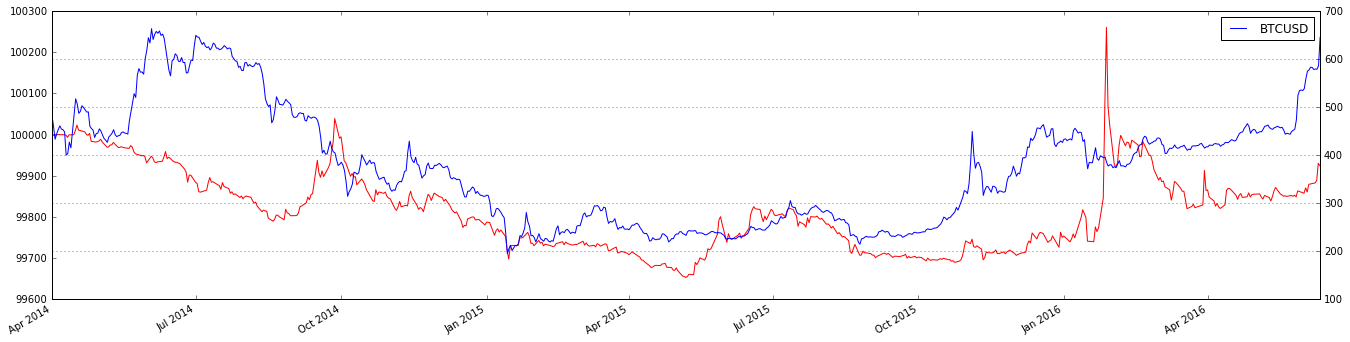

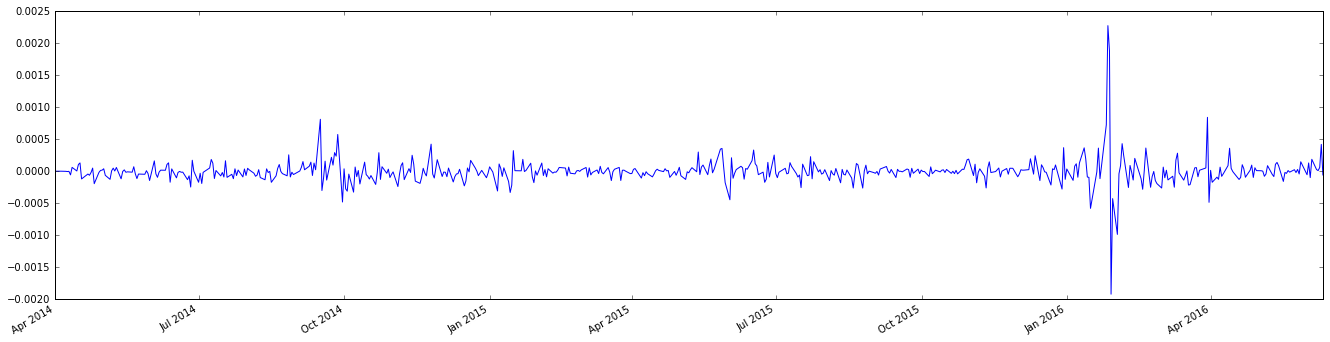

In [221]:
# This works fine
# ax1 = plt.subplot(621)
# del dogebtc['Volume']
# dogebtc.plot(ax=ax1)
# plt.ylabel('price')
# # ax1.lines.pop(4)
# plt.setp(ax1.get_xticklabels(), visible=True)

# Portfolio value

ax1 = plt.subplot(621)
ax3 = ax1.twinx()
ax1.set_frame_on(False)
perf_manual.portfolio_value.plot(ax=ax1, color='red', label='Portfolio value')
plt.plot(panel['BTCUSD']['vwap'], label='BTCUSD') 

plt.gcf().set_size_inches(50,40)
plt.legend()
plt.grid(True)
#plt.savefig('btc_vs_portfolio.png',bbox_inches='tight')
# ax1.xaxis.set_visible(False)

plt.show()

ax2 = plt.subplot(621)
perf_manual.returns.plot(ax=ax2)
plt.gcf().set_size_inches(50,40)
plt.show()


# ax1 = plt.subplot(621)
# ax3 = ax1.twinx()
# perf_manual.portfolio_value.plot(ax=ax1)
# # ax2 = plt.subplot(621)
# # perf_manual.pnl.plot(ax=ax2)
# 
# plt.gcf().set_size_inches(50,40)
# plt.show()

# edit

In [240]:
pd.Series(algo_obj.perf_tracker.cumulative_risk_metrics.to_dict())

algo_volatility              1.10457
algorithm_period_return    -0.254202
alpha                      -0.133443
benchmark_period_return     0.128363
benchmark_volatility        0.140782
beta                       0.0387113
excess_return              -0.270602
information                 -0.15726
max_drawdown                0.863365
max_leverage                       0
period_label                 2016-06
sharpe                     -0.119341
sortino                    -0.132551
trading_days                     555
treasury_period_return        0.0164
dtype: object

In [30]:
pd.Series(algo_obj.perf_tracker.cumulative_performance.to_dict())

capital_used                           -133387
ending_cash                           -33386.6
ending_exposure                         171036
ending_value                            171036
gross_leverage                         1.24255
long_exposure                           171036
long_value                              171036
longs_count                                  8
net_leverage                           1.24255
period_close         2016-06-10 23:00:00+00:00
period_open          2014-03-31 23:00:00+00:00
pnl                                      37649
portfolio_value                         137649
returns                                0.37649
short_exposure                               0
short_value                                  0
shorts_count                                 0
starting_cash                           100000
starting_exposure                            0
starting_value                               0
dtype: object

In [69]:
# algo_obj.risk_report

In [14]:
# # WITH SPY
# from zipline.data.bundles import yahoo_equities, register, yahoo 
# register('yahoo', yahoo_equities('SPY','2014-04-01','2016-06-11'))
# print register

<function register at 0x1118decf8>


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Overwriting bundle with name 'yahoo'
  app.launch_new_instance()


In [64]:
# WITH SPY
# For market-cap portfolios: 50% SPY, 50% CCETF

edit = False
if edit:
    a = np.ma.array(array, mask=False)
    a.mask[4] = True
else:
    a = array

def initialize(algo):
    algo.assets = symbols('BTCUSD','LTCUSD','DOGEBTC','SPY','XRPUSD','DASHBTC','MAIDBTC','XMRBTC','BTSBTC','BTCETH','FCTBTC',)
    algo.days = [   
                    # Days on which new asset becomes available
                    date(2014,4,1),date(2014,5,1),date(2014,7,1),date(2014,10,1),date(2015,9,1),date(2016,2,1), 
                    # Rebalancing dates, every third Friday quarterly
                    date(2014,6,20), date(2014,9,19), date(2014,12,14), date(2015,3,20), date(2015,6,19), date(2015,9,18), date(2015,12,15), date(2016,3,18), date(2016,6,17)
                ]
    
    # Slippage 
    # set_slippage(slippage.FixedSlippage(spread=0.0))
    # Commission model 
    # set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))

    #set_commission(commission.PerTrade(cost=0.00))
    
    # Slippage = default (max 2.5% of volume)
    
    # Commission model 
    set_commission(commission.PerTrade(cost=0.002))
    
def handle_data(algo, data):
    event_day = get_datetime(None).date()

    # # Buy-and-hold SPY
    # if event_day == algo.days[0]:
    #     order_target_percent(symbol('SPY'),1)

    # WEIGHTING: equal weighting (needs consistent rebalancing - right now only rebalances when new symbol data becomes available)    
    # if event_day == algo.days[0]: 
    #     for s in a[:4]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.25)
    # if event_day == algo.days[1]: 
    #     for s in a[:6]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.166)
    # if event_day == algo.days[2]:
    #     for s in a[:8]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.125)
    # if event_day == algo.days[3]:
    #     for s in a[:9]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.111)
    # if event_day == algo.days[4]:
    #     for s in a[:10]:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.1)
    # if event_day == algo.days[5]:
    #     for s in a:
    #         if s is np.ma.masked :
    #             pass
    #         else:
    #             order_target_percent(symbol(s), 0.09)
    
    # WEIGHTING: market cap weightings (no quarterly adjustments)
    # if event_day == algo.days[0]: 
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4724)
    #     order_target_percent(symbol('LTCUSD'), 0.0246)
    #     order_target_percent(symbol('DOGEBTC'), 0.0029)  
    # if event_day == algo.days[1]: 
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4672)
    #     order_target_percent(symbol('LTCUSD'), 0.0258)
    #     order_target_percent(symbol('DOGEBTC'), 0.0031) 
    #     order_target_percent(symbol('XRPUSD'), 0.0034)
    #     order_target_percent(symbol('DASHBTC'), 0.0005) 
    # if event_day == algo.days[2]:
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4798)
    #     order_target_percent(symbol('LTCUSD'), 0.143)
    #     order_target_percent(symbol('DOGEBTC'), 0.0012) 
    #     order_target_percent(symbol('XRPUSD'), 0.0017)
    #     order_target_percent(symbol('DASHBTC'), 0.0022)
    #     order_target_percent(symbol('MAIDBTC'), 0.0004)
    #     order_target_percent(symbol('XMRBTC'), 0.0003) 
    # if event_day == algo.days[3]:
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4633)
    #     order_target_percent(symbol('LTCUSD'), 0.013)
    #     order_target_percent(symbol('DOGEBTC'), 0.0032) 
    #     order_target_percent(symbol('XRPUSD'), 0.0122)
    #     order_target_percent(symbol('DASHBTC'), 0.0012)
    #     order_target_percent(symbol('MAIDBTC'), 0.0008)
    #     order_target_percent(symbol('XMRBTC'), 0.0004) 
    #     order_target_percent(symbol('BTSBTC'), 0.0059)
    # if event_day == algo.days[4]:
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4336)
    #     order_target_percent(symbol('LTCUSD'), 0.0151)
    #     order_target_percent(symbol('DOGEBTC'), 0.0016) 
    #     order_target_percent(symbol('XRPUSD'), 0.0323)
    #     order_target_percent(symbol('DASHBTC'), 0.0019)
    #     order_target_percent(symbol('MAIDBTC'), 0.0013)
    #     order_target_percent(symbol('XMRBTC'), 0.0005) 
    #     order_target_percent(symbol('BTSBTC'), 0.0011)
    #     order_target_percent(symbol('BTCETH'), 0.0126)
    # if event_day == algo.days[5]:
    #     order_target_percent(symbol('SPY'), 0.5) 
    #     order_target_percent(symbol('BTCUSD'), 0.4511)
    #     order_target_percent(symbol('LTCUSD'), 0.0108)
    #     order_target_percent(symbol('DOGEBTC'), 0.0023) 
    #     order_target_percent(symbol('XRPUSD'), 0.0174)
    #     order_target_percent(symbol('DASHBTC'), 0.002)
    #     order_target_percent(symbol('MAIDBTC'), 0.0007)
    #     order_target_percent(symbol('XMRBTC'), 0.0004) 
    #     order_target_percent(symbol('BTSBTC'), 0.0007)
    #     order_target_percent(symbol('BTCETH'), 0.0141)               
    #     order_target_percent(symbol('FCTBTC'), 0.0006)
    
    
                
    # Market cap weighting, no BTC + LTC, no quarterly adjustments
    if event_day == algo.days[0]: 
        # 
        order_target_percent(symbol('DOGEBTC'), 0.5) 
        order_target_percent(symbol('SPY'), 0.5) 
    if event_day == algo.days[1]: 
        # 
        order_target_percent(symbol('SPY'), 0.5) 
        order_target_percent(symbol('DOGEBTC'), 0.2182) 
        order_target_percent(symbol('XRPUSD'), 0.2439)
        order_target_percent(symbol('DASHBTC'), 0.0379) 
    if event_day == algo.days[2]:
        # 
        order_target_percent(symbol('SPY'), 0.5) 
        order_target_percent(symbol('DOGEBTC'), 0.1049) 
        order_target_percent(symbol('XRPUSD'), 0.1448)
        order_target_percent(symbol('DASHBTC'), 0.1909)
        order_target_percent(symbol('MAIDBTC'), 0.038)
        order_target_percent(symbol('XMRBTC'), 0.0214) 
    if event_day == algo.days[3]:
        # 
        order_target_percent(symbol('SPY'), 0.5) 
        order_target_percent(symbol('DOGEBTC'), 0.0674) 
        order_target_percent(symbol('XRPUSD'), 0.2586)
        order_target_percent(symbol('DASHBTC'), 0.0246)
        order_target_percent(symbol('MAIDBTC'), 0.0161)
        order_target_percent(symbol('XMRBTC'), 0.0086) 
        order_target_percent(symbol('BTSBTC'), 0.1247)
    if event_day == algo.days[4]:
        # 
        order_target_percent(symbol('SPY'), 0.5) 
        order_target_percent(symbol('DOGEBTC'), 0.0161) 
        order_target_percent(symbol('XRPUSD'), 0.3152)
        order_target_percent(symbol('DASHBTC'), 0.0182)
        order_target_percent(symbol('MAIDBTC'), 0.0125)
        order_target_percent(symbol('XMRBTC'), 0.0052) 
        order_target_percent(symbol('BTSBTC'), 0.0103)
        order_target_percent(symbol('BTCETH'), 0.1225)
    if event_day == algo.days[5]:
        # 
        order_target_percent(symbol('SPY'), 0.5) 
        order_target_percent(symbol('DOGEBTC'), 0.0297) 
        order_target_percent(symbol('XRPUSD'), 0.2278)
        order_target_percent(symbol('DASHBTC'), 0.0263)
        order_target_percent(symbol('MAIDBTC'), 0.0087)
        order_target_percent(symbol('XMRBTC'), 0.0056) 
        order_target_percent(symbol('BTSBTC'), 0.0088)
        order_target_percent(symbol('BTCETH'), 0.1851)               
        order_target_percent(symbol('FCTBTC'), 0.0079) 
    
algo_obj = TradingAlgorithm(initialize=initialize, handle_data=handle_data, sim_params=sim_params)
perf_manual = algo_obj.run(data=panel, overwrite_sim_params=False)

In [39]:
print a[:4]

['BTCUSD' 'LTCUSD' 'DOGEBTC' 'XRPUSD']


In [251]:
# print perf_manual['algo_volatility']

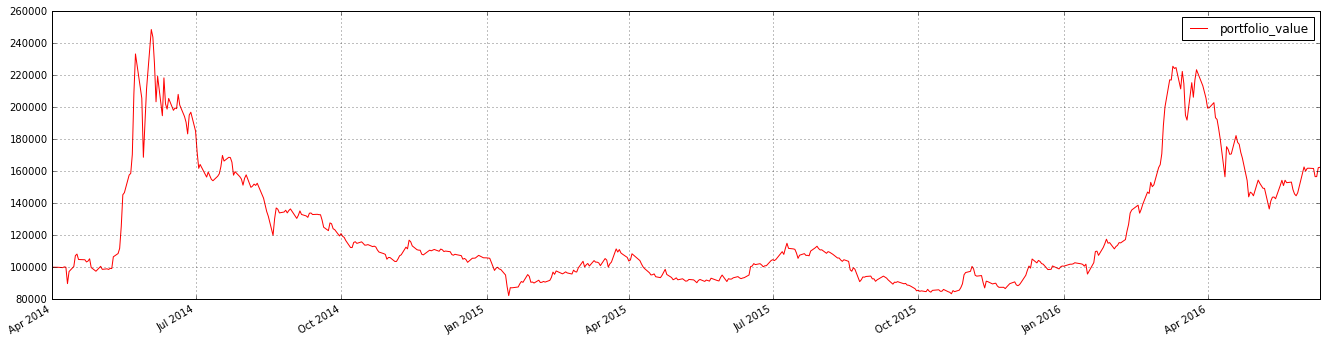

In [46]:
ax1 = plt.subplot(621)
# ax1.set_frame_on(False)
perf_manual.portfolio_value.plot(ax=ax1, color='red')

plt.gcf().set_size_inches(50,40)
plt.legend()
plt.grid(True)
#plt.savefig('btc_vs_portfolio.png',bbox_inches='tight')
# ax1.xaxis.set_visible(False)

plt.show()

In [65]:
pd.Series(algo_obj.perf_tracker.cumulative_risk_metrics.to_dict())

algo_volatility            0.286744
algorithm_period_return    0.789031
alpha                      0.323419
benchmark_period_return    0.128363
benchmark_volatility       0.140782
beta                       0.440355
excess_return              0.772631
information                 1.04615
max_drawdown               0.383535
max_leverage               0.837169
period_label                2016-06
sharpe                      1.19222
sortino                     1.86544
trading_days                    555
treasury_period_return       0.0164
dtype: object